In [1]:
# imports
from pathlib import Path
from typing import List, Tuple, Union, Set
import glob

import pandas as pd
import numpy as np

import shutil          # provides high level file operations
import time            # used to measure execution time
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from yahoo_historical import Fetcher
import yfinance as yf

In [2]:
trainingset_folder    = "D:/data_mt/09_training/"
stock_data_folder = trainingset_folder + "stocks/"
combine_data_folder = trainingset_folder + "combined/"

overwrite = False

## 01_Tools

In [3]:
import findspark
from pyspark.sql import SparkSession
def get_spark_session(appname = "default"):
    """
    Initialises a spark session. 
    Parameters:
    appname - default is "default"
    """
    findspark.init()
    return SparkSession.builder \
                        .appName(appname) \
                        .getOrCreate()

In [4]:
def load_additional_info() -> pd.DataFrame:
    return pd.read_csv(trainingset_folder + "company_info.csv", sep=',', encoding='utf-8', header=0)

In [5]:
def load_reports():
    df = pd.read_csv(trainingset_folder + "company_reports.csv", header = 0)
    df.period = pd.to_datetime(df.period)
    df.filed = pd.to_datetime(df.filed)
    return df

In [6]:
def load_stock_history(ticker:str):
    df =  pd.read_csv(trainingset_folder + "/stocks/" + ticker[0] + "/" + ticker + ".csv")
    df.Date = pd.to_datetime(df.Date)
    return df

## 02_Load data

In [7]:
add_info = load_additional_info()
fd_data = load_reports()

## 03_Merge Fundamental Data with Stockdata

Combine the fundamental data with the stockdata based on the date. For the fundamental data the "filed" date has to be used, since this is the the day when the report was published. 

Moreover, yearly and quarterly reports with the fundamental data could be published on weekends and other holidays. This has to be cleaned as well.



In [8]:
def merge_dataframes(ticker, ticker_fd_data):
    ticker_stock_data = load_stock_history(ticker)
    ticker_stock_data = ticker_stock_data[ticker_stock_data.Date > "2012-01-01"]
    ticker_stock_data['i_date'] = ticker_stock_data.Date

    ticker_stock_data.set_index('i_date', inplace=True)
    ticker_fd_data['i_date'] = ticker_fd_data.filed
    ticker_fd_data.set_index('i_date', inplace=True)

    combined_data = pd.merge(ticker_fd_data, ticker_stock_data, left_index=True, right_index=True, how='outer')
    combined_data.sort_index(inplace=True)

    combined_data = combined_data.fillna(method="ffill")
    combined_data = combined_data.dropna(subset=['filed', 'Date'])
    
    combined_data['ticker'] = combined_data.ticker_x
    combined_data.drop(columns=['ticker_x', 'ticker_y'])
    
    return combined_data

In [9]:
def create_price_ratio_features(combined_data, shares_outstanding):
    combined_data['pr_p2e'] = combined_data.Close * shares_outstanding / (
            combined_data.c_NetIncomeLoss - combined_data.c_PaymentsOfDividendsTotal)
    combined_data['pr_p2b'] = combined_data.Close * shares_outstanding / (
            combined_data.Assets - combined_data.Liabilities)
    combined_data['pr_p2egr_1y'] = combined_data.pr_p2e / (
            combined_data.gr_netincome_p * 100)  # approximated / denominator in percent

    # caping p2e: in order to prevent meaningless values, we need to restrict the range. The max value is limited to 100.
    # if new_df.c_NetIncomeLoss - new_df.c_PaymentsOfDividendsTotal results in a negativ value, we set p2e to 100, which is rather a "bad" value.
    combined_data.loc[(combined_data.pr_p2e < 0) | (combined_data.pr_p2e > 100), 'pr_p2e'] = 100
    # caping p2egr: the lower the better. generally you would like to see a ratio lower than 1, so a 5 could be a really bad value so we restrict it to 5
    # if growth number is 0 or less, we set p2egr to 5
    combined_data.loc[(combined_data.pr_p2egr_1y > 5) | (combined_data.pr_p2egr_1y <= 0.0), 'pr_p2egr_1y'] = 5

In [10]:
def find_10_day_max(date, close, df):
    date_low = date + pd.DateOffset(days=180)
    date_high =  date + pd.DateOffset(days=360)

    # return df[(df.Date >= date_low) & ((df.Date <= date_high))].Close.max()
    close_list = df[(df.Date >= date_low) & (df.Date <= date_high)].Close.sort_values(ascending=False).to_list()
    if len(close_list) >= 10:
        return close_list[9]
    return 0


def calculate_potential(combined_data):
    combined_data['c_max_10day'] = combined_data.apply(lambda row : find_10_day_max(row['Date'], row['Close'], combined_data), axis = 1)
    combined_data['r_potential'] = (combined_data.c_max_10day / combined_data.Close) - 1

In [11]:
def process_ticker(data_tuple):
    try:
        ticker          = data_tuple[0]
        ticker_fd_data  = data_tuple[1]
        ticker_add_info = data_tuple[2]

        new_file = combine_data_folder + ticker[0] + "/" + ticker + ".csv"

        if os.path.isfile(new_file) & overwrite:
            return
        print('process: ', ticker)

        shares_outstanding = ticker_add_info.sharesOutstanding.to_list()[0]

        combined_data = merge_dataframes(ticker, ticker_fd_data)

        create_price_ratio_features(combined_data, shares_outstanding)
        
        calculate_potential(combined_data)

        combined_data.to_csv(new_file, sep=',', encoding='utf-8', index=False)

    except Exception as e:
        print(e)

In [12]:
def data_generator():
    add_info = load_additional_info()
    fd_data = load_reports()
    tickers = add_info.ticker.unique()
    print(len(tickers))

    for ticker in tickers:
        ticker_fd_data = fd_data[fd_data.ticker == ticker].copy()
        ticker_add_info = add_info[add_info.ticker == ticker]

        yield ticker, ticker_fd_data, ticker_add_info

In [ ]:
for data_tuple in data_generator():
    process_ticker(data_tuple)

## 04_Combine Stockdata into a single dataset
In order to be able to normalize the stockdata, we need to have them all in a single dataset. <br>
Since we don't know how we will use them, we store the data with spark as a parquet dataset and a pure csv dataset.

In [28]:
# init Spark
spark = get_spark_session() # Session anlegen
spark # display the moste important information of the session

In [67]:
df_all = spark.read.csv(combine_data_folder + "*/*", header=True, dateFormat="yyyy-MM-dd", inferSchema=True)
df_all = df_all.withColumnRenamed("ticker_x", "ticker") \
               .drop("ticker_y")

In [82]:
from pyspark.sql.functions import to_date

df_all = df_all.withColumn("cik", df_all["cik"].cast(IntegerType())) \
               .withColumn('bs_qtrs', df_all['bs_qtrs'].cast(IntegerType())) \
               .withColumn('cf_qtrs', df_all['cf_qtrs'].cast(IntegerType())) \
               .withColumn('is_qtrs', df_all['is_qtrs'].cast(IntegerType())) \
               .withColumn('period_day_of_week', df_all['period_day_of_week'].cast(IntegerType())) \
               .withColumn('period_day_of_month', df_all['period_day_of_month'].cast(IntegerType())) \
               .withColumn('period_day_of_year', df_all['period_day_of_year'].cast(IntegerType())) \
               .withColumn('period_week_of_year', df_all['period_week_of_year'].cast(IntegerType())) \
               .withColumn('period_month_of_year', df_all['period_month_of_year'].cast(IntegerType())) \
               .withColumn('day_of_week', df_all['day_of_week'].cast(IntegerType())) \
               .withColumn('day_of_month', df_all['day_of_month'].cast(IntegerType())) \
               .withColumn('day_of_year', df_all['day_of_year'].cast(IntegerType())) \
               .withColumn('week_of_year', df_all['week_of_year'].cast(IntegerType())) \
               .withColumn('month_of_year', df_all['month_of_year'].cast(IntegerType())) \
                .withColumn('Assets', df_all['Assets'].cast(DoubleType())) \
                .withColumn('AssetsNoncurrent', df_all['AssetsNoncurrent'].cast(DoubleType())) \
                .withColumn('AssetsCurrent', df_all['AssetsCurrent'].cast(DoubleType())) \
                .withColumn('Liabilities', df_all['Liabilities'].cast(DoubleType())) \
                .withColumn('LiabilitiesNoncurrent', df_all['LiabilitiesNoncurrent'].cast(DoubleType())) \
                .withColumn('LiabilitiesCurrent', df_all['LiabilitiesCurrent'].cast(DoubleType())) \
                .withColumn('c_Equity', df_all['c_Equity'].cast(DoubleType())) \
                .withColumn('c_RetainedEarnings', df_all['c_RetainedEarnings'].cast(DoubleType())) \
                .withColumn('c_CashIncreaseDecrease', df_all['c_CashIncreaseDecrease'].cast(DoubleType())) \
                .withColumn('c_CashFromOperating', df_all['c_CashFromOperating'].cast(DoubleType())) \
                .withColumn('c_CashFromInvesting', df_all['c_CashFromInvesting'].cast(DoubleType())) \
                .withColumn('c_CashFromFinancing', df_all['c_CashFromFinancing'].cast(DoubleType())) \
                .withColumn('c_PaymentsOfDividendsTotal', df_all['c_PaymentsOfDividendsTotal'].cast(DoubleType())) \
                .withColumn('c_PaymentsForRepurchaseOfStockTotal', df_all['c_PaymentsForRepurchaseOfStockTotal'].cast(DoubleType())) \
                .withColumn('c_Revenues', df_all['c_Revenues'].cast(DoubleType())) \
                .withColumn('GrossProfit', df_all['GrossProfit'].cast(DoubleType())) \
                .withColumn('c_OperatingIncomeLoss', df_all['c_OperatingIncomeLoss'].cast(DoubleType())) \
                .withColumn('c_NetIncomeLoss', df_all['c_NetIncomeLoss'].cast(DoubleType())) \
                .withColumn('r_workcapToAssets', df_all['r_workcapToAssets'].cast(DoubleType())) \
                .withColumn('r_currentRatio', df_all['r_currentRatio'].cast(DoubleType())) \
                .withColumn('r_deptToEquity', df_all['r_deptToEquity'].cast(DoubleType())) \
                .withColumn('r_deptRatio', df_all['r_deptRatio'].cast(DoubleType())) \
                .withColumn('r_netProfitMargin', df_all['r_netProfitMargin'].cast(DoubleType())) \
                .withColumn('r_operatingMargin', df_all['r_operatingMargin'].cast(DoubleType())) \
                .withColumn('r_netIncomeMargin', df_all['r_netIncomeMargin'].cast(DoubleType())) \
                .withColumn('r_cashGenPowerRatio', df_all['r_cashGenPowerRatio'].cast(DoubleType())) \
                .withColumn('r_extFinancingIndexRatio', df_all['r_extFinancingIndexRatio'].cast(DoubleType())) \
                .withColumn('r_returnOnEquity', df_all['r_returnOnEquity'].cast(DoubleType())) \
                .withColumn('r_returnOnAssets', df_all['r_returnOnAssets'].cast(DoubleType())) \
                .withColumn('r_assetsTurnoverRatio', df_all['r_assetsTurnoverRatio'].cast(DoubleType())) \
                .withColumn('r_dividendPayoutRatio', df_all['r_dividendPayoutRatio'].cast(DoubleType())) \
                .withColumn('r_stockRepurchaseRatio', df_all['r_stockRepurchaseRatio'].cast(DoubleType())) \
                .withColumn('r_operatingCashFlowRatio', df_all['r_operatingCashFlowRatio'].cast(DoubleType())) \
                .withColumn('r_assetEfficiencyRatio', df_all['r_assetEfficiencyRatio'].cast(DoubleType())) \
                .withColumn('r_currentLiabCoverageRatio', df_all['r_currentLiabCoverageRatio'].cast(DoubleType())) \
                .withColumn('r_longtermDeptCoverageRatio', df_all['r_longtermDeptCoverageRatio'].cast(DoubleType())) \
                .withColumn('gr_revenue_n', df_all['gr_revenue_n'].cast(DoubleType())) \
                .withColumn('gr_revenue_p', df_all['gr_revenue_p'].cast(DoubleType())) \
                .withColumn('gr_grosspr_n', df_all['gr_grosspr_n'].cast(DoubleType())) \
                .withColumn('gr_grosspr_p', df_all['gr_grosspr_p'].cast(DoubleType())) \
                .withColumn('gr_opiincome_n', df_all['gr_opiincome_n'].cast(DoubleType())) \
                .withColumn('gr_opiincome_p', df_all['gr_opiincome_p'].cast(DoubleType())) \
                .withColumn('gr_netincome_n', df_all['gr_netincome_n'].cast(DoubleType())) \
                .withColumn('gr_netincome_p', df_all['gr_netincome_p'].cast(DoubleType())) \
                .withColumn('gr_earnings_n', df_all['gr_earnings_n'].cast(DoubleType())) \
                .withColumn('gr_earnings_p', df_all['gr_earnings_p'].cast(DoubleType())) \
                .withColumn('gr_equity_n', df_all['gr_equity_n'].cast(DoubleType())) \
                .withColumn('gr_equity_p', df_all['gr_equity_p'].cast(DoubleType())) \
                .withColumn('gr_asscur_n', df_all['gr_asscur_n'].cast(DoubleType())) \
                .withColumn('gr_asscur_p', df_all['gr_asscur_p'].cast(DoubleType())) \
                .withColumn('gr_assnoncur_n', df_all['gr_assnoncur_n'].cast(DoubleType())) \
                .withColumn('gr_assnoncur_p', df_all['gr_assnoncur_p'].cast(DoubleType())) \
                .withColumn('gr_liabcur_n', df_all['gr_liabcur_n'].cast(DoubleType())) \
                .withColumn('gr_liabcur_p', df_all['gr_liabcur_p'].cast(DoubleType())) \
                .withColumn('gr_liabnoncur_n', df_all['gr_liabnoncur_n'].cast(DoubleType())) \
                .withColumn('gr_liabnoncur_p', df_all['gr_liabnoncur_p'].cast(DoubleType())) \
                .withColumn('gr_cashfrominv_n', df_all['gr_cashfrominv_n'].cast(DoubleType())) \
                .withColumn('gr_cashfrominv_p', df_all['gr_cashfrominv_p'].cast(DoubleType())) \
                .withColumn('gr_cashfromfin_n', df_all['gr_cashfromfin_n'].cast(DoubleType())) \
                .withColumn('gr_cashfromfin_p', df_all['gr_cashfromfin_p'].cast(DoubleType())) \
                .withColumn('gr_cashfromope_n', df_all['gr_cashfromope_n'].cast(DoubleType())) \
                .withColumn('gr_cashfromope_p', df_all['gr_cashfromope_p'].cast(DoubleType())) \
                .withColumn('gr_dividends_n', df_all['gr_dividends_n'].cast(DoubleType())) \
                .withColumn('gr_dividends_p', df_all['gr_dividends_p'].cast(DoubleType())) \
                .withColumn('fp__FY', df_all['fp__FY'].cast(DoubleType())) \
                .withColumn('fp__Q1', df_all['fp__Q1'].cast(DoubleType())) \
                .withColumn('fp__Q2', df_all['fp__Q2'].cast(DoubleType())) \
                .withColumn('fp__Q3', df_all['fp__Q3'].cast(DoubleType())) \
                .withColumn('fp__Q4', df_all['fp__Q4'].cast(DoubleType())) \
                .withColumn('year', df_all['year'].cast(DoubleType())) \
                .withColumn('Open', df_all['Open'].cast(DoubleType())) \
                .withColumn('High', df_all['High'].cast(DoubleType())) \
                .withColumn('Low', df_all['Low'].cast(DoubleType())) \
                .withColumn('Close', df_all['Close'].cast(DoubleType())) \
                .withColumn('Volume', df_all['Volume'].cast(DoubleType())) \
                .withColumn('close_norm', df_all['close_norm'].cast(DoubleType())) \
                .withColumn('high_norm', df_all['high_norm'].cast(DoubleType())) \
                .withColumn('low_norm', df_all['low_norm'].cast(DoubleType())) \
                .withColumn('open_norm', df_all['open_norm'].cast(DoubleType())) \
                .withColumn('volume_norm', df_all['volume_norm'].cast(DoubleType())) \
                .withColumn('close_chg', df_all['close_chg'].cast(DoubleType())) \
                .withColumn('volume_chg', df_all['volume_chg'].cast(DoubleType())) \
                .withColumn('pr_p2e', df_all['pr_p2e'].cast(DoubleType())) \
                .withColumn('pr_p2b', df_all['pr_p2b'].cast(DoubleType())) \
                .withColumn('pr_p2egr_1y', df_all['pr_p2egr_1y'].cast(DoubleType())) \
                .withColumn('c_max_10day', df_all['c_max_10day'].cast(DoubleType())) \
                .withColumn('r_potential', df_all['r_potential'].cast(DoubleType())) \
                .withColumn('period', to_date(df_all['period'], 'yyyy-MM-dd')) \
                .withColumn('filed', to_date(df_all['filed'], 'yyyy-MM-dd')) \
                .withColumn('Date', to_date(df_all['Date'], 'yyyy-MM-dd')) \

In [84]:
from pyspark.sql.functions import col

shutil.rmtree(trainingset_folder + "/all_combine_data", ignore_errors = True)

df_all_partioned = df_all.repartition(16, col("ticker"))
df_all_partioned.write.parquet(trainingset_folder + "/all_combine_data")

In [86]:
spark.stop()

## XX_Trials

In [134]:
fd_calc_cols = ['period','c_NetIncomeLoss', 'c_PaymentsOfDividendsTotal', 'Assets', 'Liabilities']

fd_train_cols = ['r_workcapToAssets', 'r_currentRatio', 'r_deptToEquity', 'r_deptRatio',
       'r_netProfitMargin', 'r_operatingMargin', 'r_netIncomeMargin',
       'r_cashGenPowerRatio', 'r_extFinancingIndexRatio', 'r_returnOnEquity',
       'r_returnOnAssets', 'r_assetsTurnoverRatio', 'r_dividendPayoutRatio',
       'r_stockRepurchaseRatio', 'r_operatingCashFlowRatio',
       'r_assetEfficiencyRatio', 'r_currentLiabCoverageRatio',
       'r_longtermDeptCoverageRatio', 'gr_revenue_n', 'gr_revenue_p',
       'gr_grosspr_n', 'gr_grosspr_p', 'gr_opiincome_n', 'gr_opiincome_p',
       'gr_netincome_n', 'gr_netincome_p', 'gr_earnings_n', 'gr_earnings_p',
       'gr_equity_n', 'gr_equity_p', 'gr_asscur_n', 'gr_asscur_p',
       'gr_assnoncur_n', 'gr_assnoncur_p', 'gr_liabcur_n', 'gr_liabcur_p',
       'gr_liabnoncur_n', 'gr_liabnoncur_p', 'gr_cashfrominv_n',
       'gr_cashfrominv_p', 'gr_cashfromfin_n', 'gr_cashfromfin_p',
       'gr_cashfromope_n', 'gr_cashfromope_p', 'gr_dividends_n',
       'gr_dividends_p', 'fp__FY', 'fp__Q1', 'fp__Q2', 'fp__Q3', 'fp__Q4']

stock_train_cols = ['close_norm',
       'high_norm', 'low_norm', 'open_norm', 'volume_norm', 'close_chg',
       'volume_chg', 'day_of_week', 'day_of_month', 'day_of_year',
       'week_of_year', 'month_of_year',]

In [9]:
aapl_info = add_info[add_info.ticker == "AAPL"]
aapl_info_shares = aapl_info.sharesOutstanding.to_list()[0]
aapl_info_shares

17102499840.0

In [10]:
aapl = load_stock_history("AAPL")
aapl = aapl[aapl.Date > "2012-01-01"]
aapl.shape

(2250, 19)

In [11]:
fd_data_aapl = fd_data[fd_data.ticker == 'AAPL'].copy()
fd_data_aapl.shape

(34, 85)

In [12]:
aapl['i_date'] = aapl.Date
aapl.set_index('i_date',inplace=True)

In [13]:
fd_data_aapl['i_date'] = fd_data_aapl.filed
fd_data_aapl.set_index('i_date',inplace=True)

In [14]:
new_df = pd.merge(fd_data_aapl, aapl, left_index=True, right_index=True,  how='outer')
new_df.sort_index(inplace=True)
new_df.shape

(2250, 104)

In [15]:
# new_df[fd_train_cols] = new_df[fd_train_cols].fillna(method="ffill")
# new_df[fd_calc_cols] = new_df[fd_calc_cols].fillna(method="ffill")

new_df = new_df.fillna(method="ffill")
new_df = new_df.fillna(method="ffill")
new_df = new_df.dropna(subset=['filed', 'Date'])

In [16]:
print(sum(new_df.period.isna()))
print(sum(new_df.Date.isna()))

0
0


In [17]:
new_df['pr_p2e']      = new_df.Close * aapl_info_shares / (new_df.c_NetIncomeLoss - new_df.c_PaymentsOfDividendsTotal)
new_df['pr_p2b']      = new_df.Close * aapl_info_shares / (new_df.Assets - new_df.Liabilities)
new_df['pr_p2egr_1y'] = new_df.pr_p2e / (new_df.gr_netincome_p * 100)  # approximated / denominator in percent

In [18]:
# caping p2e: in order to prevent meaningless values, we need to restrict the range. The max value is limited to 100. 
# if new_df.c_NetIncomeLoss - new_df.c_PaymentsOfDividendsTotal results in a negativ value, we set p2e to 100, which is rather a "bad" value.
new_df.loc[(new_df.pr_p2e < 0) | (new_df.pr_p2e > 100), 'pr_p2e'] = 100

# caping p2egr: the lower the better. generally you would like to see a ratio lower than 1, so a 5 could be a really bad value so we restrict it to 5
# if growth number is 0 or less, we set p2egr to 5
new_df.loc[(new_df.pr_p2egr_1y > 5) | (new_df.pr_p2egr_1y <= 0.0), 'pr_p2egr_1y'] = 5

In [19]:
new_df[(new_df.index > "2012-07-20") & (new_df.index < "2012-08-05")][['period','filed','r_workcapToAssets', 'r_currentRatio', 'r_deptToEquity', 'r_deptRatio']]

,period,filed,r_workcapToAssets,r_currentRatio,r_deptToEquity,r_deptRatio
i_date,,,,,,
2012-07-23,2012-03-31,2012-04-25,0.368276,1.582969,0.472556,0.320908
2012-07-24,2012-03-31,2012-04-25,0.368276,1.582969,0.472556,0.320908
2012-07-25,2012-06-30,2012-07-25,0.363533,1.571174,0.457735,0.314004
2012-07-26,2012-06-30,2012-07-25,0.363533,1.571174,0.457735,0.314004
2012-07-27,2012-06-30,2012-07-25,0.363533,1.571174,0.457735,0.314004
2012-07-30,2012-06-30,2012-07-25,0.363533,1.571174,0.457735,0.314004
2012-07-31,2012-06-30,2012-07-25,0.363533,1.571174,0.457735,0.314004
2012-08-01,2012-06-30,2012-07-25,0.363533,1.571174,0.457735,0.314004
2012-08-02,2012-06-30,2012-07-25,0.363533,1.571174,0.457735,0.314004


In [51]:
new_df[fd_train_cols] = new_df[fd_train_cols].fillna(method="ffill")

In [52]:
new_df[(new_df.index > "2012-06-27") & (new_df.index < "2012-07-03")][['r_workcapToAssets', 'r_currentRatio', 'r_deptToEquity', 'r_deptRatio']]

,r_workcapToAssets,r_currentRatio,r_deptToEquity,r_deptRatio
i_date,,,,
2012-06-28,0.368276,1.582969,0.472556,0.320908
2012-06-29,0.368276,1.582969,0.472556,0.320908
2012-06-30,0.363533,1.571174,0.457735,0.314004
2012-07-02,0.363533,1.571174,0.457735,0.314004


In [133]:
new_df[new_df.c_NetIncomeLoss.isna()]

,cik,ticker_x,adsh,period,filed,form,bs_qtrs,fp,Assets,AssetsNoncurrent,...,open_norm,volume_norm,close_chg,volume_chg,day_of_week,day_of_month,day_of_year,week_of_year,month_of_year,ticker_y
i_date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,-0.004450,0.017671,0.015382,0.682163,0.142857,0.096774,0.008219,0.019231,0.083333,AAPL
2012-01-04,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,-0.008320,0.015204,0.005374,-0.139629,0.285714,0.129032,0.010959,0.019231,0.083333,AAPL
2012-01-05,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,-0.007368,0.015861,0.011102,0.043256,0.428571,0.161290,0.013699,0.019231,0.083333,AAPL
2012-01-06,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,-0.006226,0.018611,0.010454,0.173345,0.571429,0.193548,0.016438,0.019231,0.083333,AAPL
2012-01-09,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,0.008939,0.023039,-0.001586,0.237931,0.000000,0.290323,0.024658,0.038462,0.083333,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-03-26,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,-0.011845,0.034834,0.018337,0.383873,0.000000,0.838710,0.235616,0.250000,0.250000,AAPL
2012-03-27,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,-0.013507,0.035499,0.012356,0.019115,0.142857,0.870968,0.238356,0.250000,0.250000,AAPL
2012-03-28,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,0.001230,0.038325,0.005110,0.079605,0.285714,0.903226,0.241096,0.250000,0.250000,AAPL


In [99]:
#new_df = pd.merge(fd_data_aapl, aapl[['ticker', 'Date']],  how='outer', left_on=['ticker','period'], right_on = ['ticker','Date'])


In [23]:
aapl.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'close_norm',
       'high_norm', 'low_norm', 'open_norm', 'volume_norm', 'close_chg',
       'volume_chg', 'day_of_week', 'day_of_month', 'day_of_year',
       'week_of_year', 'month_of_year', 'ticker'],
      dtype='object')

In [22]:
fd_data_aapl.columns

Index(['cik', 'ticker', 'adsh', 'period', 'filed', 'form', 'bs_qtrs', 'fp',
       'Assets', 'AssetsNoncurrent', 'AssetsCurrent', 'Liabilities',
       'LiabilitiesNoncurrent', 'LiabilitiesCurrent', 'c_Equity',
       'c_RetainedEarnings', 'cf_qtrs', 'c_CashIncreaseDecrease',
       'c_CashFromOperating', 'c_CashFromInvesting', 'c_CashFromFinancing',
       'c_PaymentsOfDividendsTotal', 'c_PaymentsForRepurchaseOfStockTotal',
       'is_qtrs', 'c_Revenues', 'GrossProfit', 'c_OperatingIncomeLoss',
       'c_NetIncomeLoss', 'period_day_of_week', 'period_day_of_month',
       'period_day_of_year', 'period_week_of_year', 'period_month_of_year',
       'r_workcapToAssets', 'r_currentRatio', 'r_deptToEquity', 'r_deptRatio',
       'r_netProfitMargin', 'r_operatingMargin', 'r_netIncomeMargin',
       'r_cashGenPowerRatio', 'r_extFinancingIndexRatio', 'r_returnOnEquity',
       'r_returnOnAssets', 'r_assetsTurnoverRatio', 'r_dividendPayoutRatio',
       'r_stockRepurchaseRatio', 'r_operatingCas

In [100]:
new_df.shape

(2768, 86)

In [101]:
print(sum(new_df.period.isna()))
print(sum(new_df.Date.isna()))

2734
13


In [103]:
new_df[['period','Date']]

,period,Date
0,2012-03-31,NaT
1,2012-06-30,NaT
2,2012-09-30,NaT
3,2012-12-31,2012-12-31
4,2013-03-31,NaT
...,...,...
2763,NaT,2020-12-03
2764,NaT,2020-12-04
2765,NaT,2020-12-07
2766,NaT,2020-12-08


<AxesSubplot:>

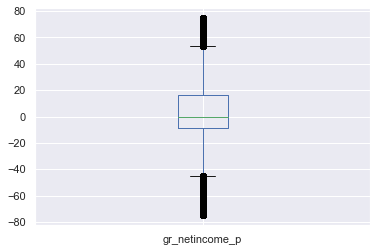

In [101]:
#df.fillna(method='ffill')

(fd_data.gr_netincome_p * 100).plot.box()

<AxesSubplot:xlabel='i_date'>

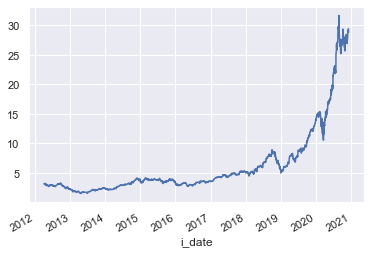

In [168]:
new_df.pr_p2b.plot()

In [95]:
just_close = new_df[['Date','Close']].copy()

In [78]:
just_close['Date_p1'] = just_close.Date + pd.DateOffset(days=180)
just_close['Date_p2'] = just_close.Date + pd.DateOffset(days=360)

In [79]:
just_close[(just_close.Date >= just_close.Date_p1) & (just_close.Date <= just_close.Date_p2)].Close.max()

nan

In [84]:
def find_10_day_max(date, close, df):      
    date_low = date + pd.DateOffset(days=180)
    date_high =  date + pd.DateOffset(days=360)

    # return df[(df.Date >= date_low) & ((df.Date <= date_high))].Close.max()
    list = df[(df.Date >= date_low) & ((df.Date <= date_high))].Close.sort_values(ascending=False).to_list()
    if len(list) >=10:
        return list[9]
    return 0

In [85]:
just_close['max_10day'] = just_close.apply(lambda row : find_10_day_max(row['Date'], row['Close'], just_close), axis = 1) 

In [88]:
just_close['potential'] = (just_close.max_10day / just_close.Close) - 1

In [89]:
print(sum(just_close['max_10day'].isna()))
just_close

0


,Date,Close,Date_p1,Date_p2,max,max_10day,potential
i_date,,,,,,,
2012-04-25,2012-04-25,18.640848,2012-10-22,2013-04-20,18.072315,18.072315,-0.030499
2012-04-26,2012-04-26,18.570557,2012-10-23,2013-04-21,18.044258,18.044258,-0.028340
2012-04-27,2012-04-27,18.426937,2012-10-24,2013-04-22,18.028843,18.028843,-0.021604
2012-04-30,2012-04-30,17.845701,2012-10-27,2013-04-25,17.887642,17.887642,0.002350
2012-05-01,2012-05-01,17.789177,2012-10-28,2013-04-26,17.887642,17.887642,0.005535
...,...,...,...,...,...,...,...
2020-12-03,2020-12-03,122.940002,2021-06-01,2021-11-28,0.000000,0.000000,-1.000000
2020-12-04,2020-12-04,122.250000,2021-06-02,2021-11-29,0.000000,0.000000,-1.000000
2020-12-07,2020-12-07,123.750000,2021-06-05,2021-12-02,0.000000,0.000000,-1.000000


<AxesSubplot:xlabel='i_date'>

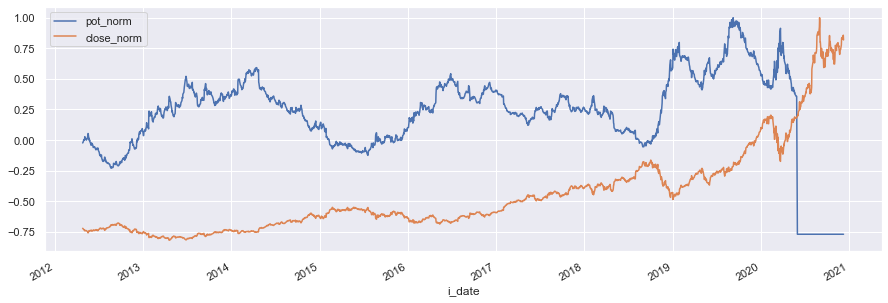

In [94]:
just_close['pot_norm'] = just_close.potential / just_close.potential.max()
just_close['close_norm'] = (just_close.Close / just_close.Close.max()) * 2 - 1
just_close[['pot_norm','close_norm']].plot(figsize = (15,5))

In [162]:
def max_10_days(np_arr):
    print(np_arr)
    if len(np_arr) > 10:
        np_arr[::-1].sort()
        print(np_arr)
        return np_arr[9]
    return 0

In [163]:
max_10_days(np.random.randint(1,20, 20))

[17  3  9 16  7 18  7  2  4  6  2 19 18  1 18  7 16  3 14 11]
[19 18 18 18 17 16 16 14 11  9  7  7  7  6  4  3  3  2  2  1]


9

In [165]:
just_close['max_10days'] = just_close.Close[0:200].rolling(180, closed="left").apply(max_10_days, raw = True)

[18.64084816 18.57055664 18.4269371  17.84570122 17.78917694 17.9068203
 17.77969742 17.27334213 17.40260124 17.36287689 17.39343262 17.43438721
 17.31795311 17.05851364 16.90419006 16.68753242 16.19981766 16.20775604
 17.1520195  17.02031517 17.43560219 17.27548218 17.18288803 17.48786354
 17.69871521 17.65471268 17.14315987 17.2440052  17.1993885  17.46310806
 17.47105408 17.73385811 17.45424843 17.60673904 17.4845047  17.46524811
 17.54470062 17.90071487 17.95052147 17.89948845 17.65288162 17.78825569
 17.44202995 17.48053169 17.55601311 17.38946342 17.84631348 18.10667801
 18.31722832 18.63901138 18.51494026 18.75971603 18.58614922 18.47063637
 18.30164528 18.48713493 18.54642105 18.54733276 18.52655602 18.7728653
 18.46665955 18.45229912 18.3633728  17.57037354 17.56761932 17.88176727
 18.18338394 18.66407776 18.54336548 18.57330704 18.81503296 19.02436066
 18.97424316 18.94215202 19.05017853 19.07995415 19.33467865 19.38654709
 19.36014557 19.5292511  19.8904686  20.41343117 20.1

In [166]:
just_close

,Date,Close,max_10days
i_date,,,
2012-04-25,2012-04-25,18.640848,NaN
2012-04-26,2012-04-26,18.570557,NaN
2012-04-27,2012-04-27,18.426937,NaN
2012-04-30,2012-04-30,17.845701,NaN
2012-05-01,2012-05-01,17.789177,NaN
...,...,...,...
2020-12-03,2020-12-03,122.940002,NaN
2020-12-04,2020-12-04,122.250000,NaN
2020-12-07,2020-12-07,123.750000,NaN


<AxesSubplot:xlabel='i_date'>

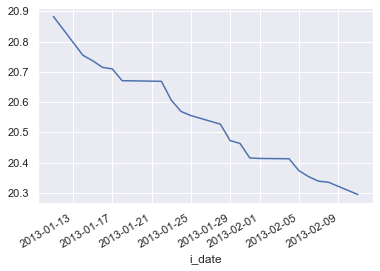

In [167]:
just_close.max_10days.plot()